In this notebook I'll be attempting to optimize a finite state controller using a Quadratically constrainted linear program (QCLP) formulation of the problem using the pyomo modeling framework and the Ipopt solver

In [19]:
from pyomo.environ import *

In [20]:
from itertools import product
import numpy as np
import random

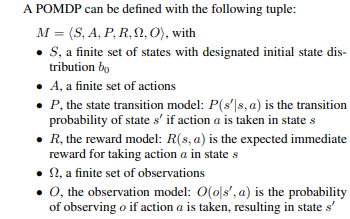

In [21]:
#Define POMDP parameters

num_states = 2 # Number of states
num_actions = 3 # Number of actions
num_observations = 2 # Number of observations

s = list(range(num_states))  # Heads or Tails
a = list(range(num_actions)) # Predict Heads, Predict Tails, Observe
o = list(range(num_observations))  # Observed Heads, Observed Tails

b0 = np.array([0.5, 0.5]) # Initial distribution over states
gamma = 0.9 # Discount factor 

# P(s'|s,a)
state_transition_model = np.ones((num_states, num_actions, num_states)) / num_states

# R(s,a)
reward_model = np.zeros((num_states, num_actions))
reward_model[0, :-1] = [10, -1] 
reward_model[1, :-1] = [-1, 10]


# O(o|s',a)
observation_model = np.ones((num_states, num_actions, num_observations)) / num_observations

In [22]:
def softmax(x: np.ndarray):
    e = np.apply_along_axis(lambda t: np.exp(t), -1, x)
    return x / e

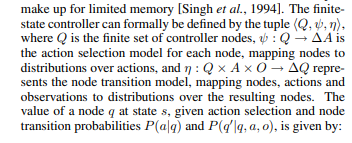

In [23]:
# Finite state controller

np.random.seed(0)

num_nodes = 3
q = list(range(num_nodes)) # Nodes in the FSC
node_transition_model = np.random.random((num_nodes, num_actions, num_nodes))
sum_over_nodes = np.linalg.norm(node_transition_model, ord=1, axis=-1, keepdims=True) # P(q'|q,a)
node_transition_model /= sum_over_nodes

# P(a|q)
action_selection_model = np.array([
  [1/3, 1/3, 1/3],  
  [0.8, 0.1, 0.1],
  [0.1, 0.8, 0.1]
])

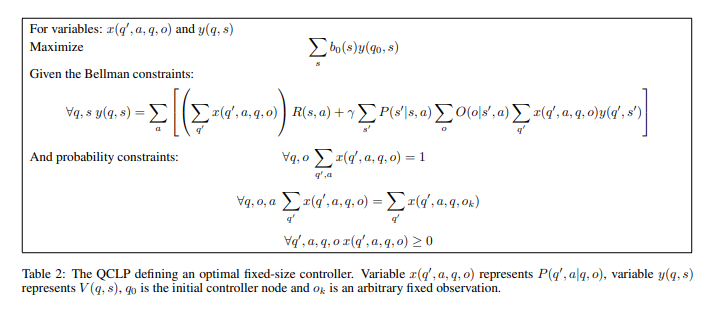

In [24]:
model = ConcreteModel()



model.q = RangeSet(0,len(q)-1)
model.a = RangeSet(0,len(a)-1)
model.o = RangeSet(0,len(o)-1)
model.s = RangeSet(0,len(s)-1)

# Variables
## x(q', a, q, o) = P(q', a | q, o)
model.x = Var(model.q,model.a,model.q,model.o, bounds = (0.0,1.0))

## y(q, s) = V(q , s)
model.y = Var(model.q,model.s )

# Objective
q0 = 0
model.Obj = Objective(expr = sum([b0[s_]*model.y[q0,s_] for s_ in s]) , sense = maximize)


# Constraints
## Probability constraints
model. sum_over_action_and_qp = ConstraintList()
for q_,o_ in product(q,o):
    model. sum_over_action_and_qp.add(sum([model.x[qp_,a_,q_,o_] for qp_,a_ in product(q,a)]) == 1) 


model.sum_independence_on_o = ConstraintList()
for q_, o_, a_ in product(q, o, a):
    model.sum_independence_on_o.add(sum([model.x[qp_, a_, q_, o_] for qp_ in q]) == sum([model.x[qp_, a_, q_, 0] for qp_ in q])) 

## Bellman equation constraints
model.bellman_equation = ConstraintList()
for q_, s_ in product(q, s):
    model.bellman_equation.add( model.y[q_, s_] == sum([ 
                ### The 0 in this line should be o_, but the constraint means we can keep it as 0
                sum([model.x[qp_, a_, q_, 0]  for qp_ in q]) * \
                reward_model[s_, a_] + \
                gamma * sum([
                    state_transition_model[s_, a_, sp_] *  \
                    sum([
                        observation_model[sp_, a_, o_] * \
                            sum([model.x[qp_, a_, q_, o_] * model.y[qp_, sp_] for qp_ in q])            
                        for o_ in o
                    ])
                    for sp_ in s
                ]) 
                for a_ in a
            ])) 


In [25]:
opt = SolverFactory('ipopt')
res = opt.solve(model) 
print(res.write())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 30
  Number of variables: 60
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.16974687576293945
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
None


In [26]:
print(model.y.display())

y : Size=6, Index=y_index
    Key    : Lower : Value               : Upper : Fixed : Stale : Domain
    (0, 0) :  None :   45.00001902723278 :  None : False : False :  Reals
    (0, 1) :  None :    45.0000320620108 :  None : False : False :  Reals
    (1, 0) :  None : 0.13020315325101972 :  None : False : False :  Reals
    (1, 1) :  None : 0.13020315325101972 :  None : False : False :  Reals
    (2, 0) :  None : 0.13020315372775712 :  None : False : False :  Reals
    (2, 1) :  None : 0.13020315372775712 :  None : False : False :  Reals
None


In [27]:
print(model.x.display())

x : Size=54, Index=x_index
    Key          : Lower : Value                  : Upper : Fixed : Stale : Domain
    (0, 0, 0, 0) :   0.0 :     0.4999994424184152 :   1.0 : False : False :  Reals
    (0, 0, 0, 1) :   0.0 :     0.4999994424184151 :   1.0 : False : False :  Reals
    (0, 0, 1, 0) :   0.0 :  4.144531026186368e-05 :   1.0 : False : False :  Reals
    (0, 0, 1, 1) :   0.0 : 4.1445310261861525e-05 :   1.0 : False : False :  Reals
    (0, 0, 2, 0) :   0.0 :  4.144531178560371e-05 :   1.0 : False : False :  Reals
    (0, 0, 2, 1) :   0.0 :  4.144531178560195e-05 :   1.0 : False : False :  Reals
    (0, 1, 0, 0) :   0.0 :     0.5000006273982356 :   1.0 : False : False :  Reals
    (0, 1, 0, 1) :   0.0 :     0.5000006273982356 :   1.0 : False : False :  Reals
    (0, 1, 1, 0) :   0.0 :  4.144531026186377e-05 :   1.0 : False : False :  Reals
    (0, 1, 1, 1) :   0.0 :  4.144531026186138e-05 :   1.0 : False : False :  Reals
    (0, 1, 2, 0) :   0.0 :  4.144531178560371e-05 :   1.0 : 

In [28]:
print(model.Obj.display())

Obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 45.00002554462179
None
